In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import StringIO
import os

In [3]:
def Save_Genreal_Report(corr_matrix, dup, head, tail, des, null, info, shape):
    #  report = input("Enter the file name to save the report (e.g., report.txt): ")
     try:
        folder_path = input("Enter the full path or name of the folder to save the report and heatmap: ").strip()
        os.makedirs(folder_path, exist_ok=True)
        report = os.path.join(folder_path, "report.txt")
        heatmap_file = os.path.join(folder_path, "correlation_heatmap.png")
        plt.figure(figsize=(8, 6))
        plt.imshow(corr_matrix, cmap='coolwarm', interpolation='nearest')
        plt.colorbar()
        plt.xticks(np.arange(len(corr_matrix.columns)), corr_matrix.columns, rotation=45, fontsize=12)
        plt.yticks(np.arange(len(corr_matrix.columns)), corr_matrix.columns, rotation=45, fontsize=12)
        plt.title('Correlation Matrix Heatmap', fontsize=14)
        plt.tight_layout()
        plt.savefig(heatmap_file)  
        plt.close()
        with open(report, 'w') as f:
            f.write("GENERAL ANALYSIS OF THE DATAFRAME\n")
            f.write("*" * 50 + "\n\n")
            f.write("-" * 50 + "\n")
            f.write(f"Shape of DataFrame: {shape}\n")
            f.write("-" * 50 + "\n\n\n")
            f.write("-" * 50 + "\n")
            f.write("Column Information:\n")
            f.write("-" * 50 + "\n")
            f.write(info + "\n") 
            f.write("\n\n\n")
            f.write("-" * 50 + "\n")
            f.write("Missing Values in Each Column:\n")
            f.write("-" * 50 + "\n")
            f.write(str(null) + "\n")
            f.write("\n\n\n")
            f.write("-" * 50 + "\n")
            f.write("Descriptive Statistics (Numerical):\n")
            f.write("-" * 50 + "\n")
            f.write(str(des) + "\n")
            f.write("\n\n\n")
            f.write("-" * 50 + "\n")
            f.write("First 5 Rows of the DataFrame:\n")
            f.write("-" * 50 + "\n")
            f.write(str(head) + "\n")
            f.write("\n\n\n")
            f.write("-" * 50 + "\n")
            f.write("Last 5 Rows of the DataFrame:\n")
            f.write("-" * 50 + "\n")
            f.write(str(tail) + "\n")
            f.write("\n\n\n")
            f.write("-" * 50 + "\n")
            f.write(f"Number of Duplicate Rows: {dup}\n")
            f.write("-" * 50 + "\n\n\n")
            f.write("-" * 50 + "\n")
            f.write("Correlation Matrix (Numerical Columns):\n")
            f.write("-" * 50 + "\n")
            f.write(str(corr_matrix) + "\n")
            f.write("\n\n")
        
        print(f"Report successfully saved as '{report}'.")
     except Exception as e:
        print(f"Error: {e}")

    

In [4]:
def General_Analysis(df):
    print("GENERAL ANALYSIS OF THE DATAFRAME")
    print("*" * 50)
    print("\n" + "\n")
    shape=df.shape
    print("-" * 50)
    print(f"Shape of DataFrame: {shape}" )
    print("-" * 50)
    print("\n" + "\n")
    print("-" * 50)
    print("Column Information:")
    print("-" * 50)
    buffer = StringIO()
    df.info(buf=buffer)  # Write the info to the buffer
    info = buffer.getvalue()
    print(info)
    print("\n" + "\n")
    print("-" * 50)
    print("Missing Values in Each Column:")
    print("-" * 50)
    null=df.isnull().sum()
    print(null)
    print("\n" + "\n")

    numdf = df.select_dtypes(include=['number'])
    print("-" * 50)
    print("Descriptive Statistics (Numerical):")
    print("-" * 50)
    des=numdf.describe()
    print(des )
    print("\n" + "\n")

    
    print("-" * 50)
    print("First 5 Rows of the DataFrame:")
    print("-" * 50)
    head=df.head()
    print(head )
    print("\n" + "\n")

    print("-" * 50)
    print("Last 5 Rows of the DataFrame:")
    print("-" * 50)
    tail=df.tail()
    print(tail )
    print("\n" + "\n")

    print("-" * 50)
    dup=df.duplicated().sum()
    print(f"Number of Duplicate Rows: {dup}" )
    print("-" * 50)
    print("\n" + "\n")

    print("-" * 50)
    print("Correlation Matrix (Numerical Columns):")
    print("-" * 50)
    # numdf = df.apply(pd.to_numeric, errors='coerce')
    corr_matrix=numdf.corr()
    print(corr_matrix )
    print("\n" )

    print("-" * 50)
    plt.figure(figsize=(8, 6))
    plt.imshow(corr_matrix, cmap='coolwarm', interpolation='nearest')
    plt.colorbar()
    plt.xticks(np.arange(len(corr_matrix.columns)), corr_matrix.columns, rotation=45, fontsize=12)
    plt.yticks(np.arange(len(corr_matrix.columns)), corr_matrix.columns, rotation=45, fontsize=12)
    plt.title('Correlation Matrix Heatmap', fontsize=14)
    plt.tight_layout()
    plt.show()
    print("-" * 50 ) 
    # print("", end="")
    save=input('Save General Report? (Y/N):')
    if save.lower()=="y":
        Save_Genreal_Report(corr_matrix, dup, head, tail, des, null, info, shape)
 
    


In [5]:
def Analyze_Data(df):
    b=True
    while(b):
        print("1. General Analysis")
        print("2. Custom Analysis")
        print("3. Return")
        choice=input("Enter Choice: ").strip()
        if(choice=="1"):
           General_Analysis(df)
        elif(choice=="2"):
            print(2)
            pass
        elif(choice=="3"):
          # print("Exiting Program...")
          b=False
        else:
          print("Please Enter Valid Choice !")

In [6]:
def Load_Data():
    b=True
    while(b):
        print("1. Analyze CSV File")
        print("2. Analyze Parquet File")
        print("3. Analyze Excel File")
        print("4. Return")
        choice=input("Enter Choice: ").strip()
        if(choice=="1"):
          path = input("Enter File Path of CSV File: ")
          try:
              df = pd.read_csv(path, encoding='unicode_escape')
              Analyze_Data(df)
          except (FileNotFoundError, Exception) as e:
              print(f"Error: {e}")
              print("CSV File not found. Try again !")
               
        elif(choice=="2"):
              path = input("Enter File Path of Parquet File: ")
              try:
                  df = pd.read_csv(path)
                  Analyze_Data(df)
              except (FileNotFoundError, Exception) as e:
                  print(f"Error: {e}")
                  print("Parquet File not found. Try again !")
        elif(choice=="3"):
              path = input("Enter File Path of Excel File: ")
              try:
                  df = pd.read_csv(path)
                  Analyze_Data(df)
              except (FileNotFoundError, Exception) as e:
                  print(f"Error: {e}")
                  print("Excel File not found. Try again !")
        elif(choice=="4"):
          # print("Exiting Program...")
          b=False
        else:
          print("Please Enter Valid Choice !")


In [7]:
def Edit_Data():
    b = True
    while b:
        print("1. Add a New Row")
        print("2. Update an Existing Row")
        print("3. Delete a Row")
        print("4. Edit Specific Column Data")
        print("5. Fill Missing Data")
        print("6. Rename Columns")
        print("7. Change Data Type of a Column")
        print("8. Sort Data")
        print("9. Filter Data")
        print("10. Remove Duplicates")
        print("11. Return")
        
        choice = input("Enter Choice: ")
        
        if choice == "1":
            print("Adding a new row...")
            pass
        elif choice == "2":
            print("Updating an existing row...")
            pass
        elif choice == "3":
            print("Deleting a row...")
            pass
        elif choice == "4":
            print("Editing specific column data...")
            pass
        elif choice == "5":
            print("Filling missing data...")
            pass
        elif choice == "6":
            print("Renaming columns...")
            pass
        elif choice == "7":
            print("Changing data type of a column...")
            pass
        elif choice == "8":
            print("Sorting data...")
            pass
        elif choice == "9":
            print("Filtering data...")
            pass
        elif choice == "10":
            print("Removing duplicates...")
            pass
        elif choice == "11":
            print("Returning to main menu...")
            b = False
        else:
            print("Please Enter a Valid Choice!")


1. Analyze Data
2. Edit Data
3. Cleaning Data
4. Sort Folder
5. Exit
1. Analyze CSV File
2. Analyze Parquet File
3. Analyze Excel File
4. Return
1. General Analysis
2. Custom Analysis
3. Return
GENERAL ANALYSIS OF THE DATAFRAME
**************************************************



--------------------------------------------------
Shape of DataFrame: (132000, 30)
--------------------------------------------------



--------------------------------------------------
Column Information:
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132000 entries, 0 to 131999
Data columns (total 30 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Country                      132000 non-null  object 
 1   Year                         132000 non-null  int64  
 2   Month                        132000 non-null  object 
 3   Day of Week                  132000 non-null  o

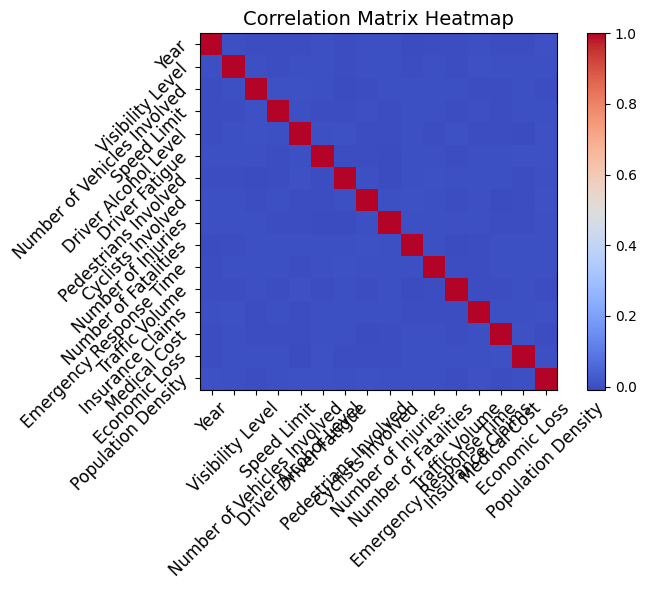

--------------------------------------------------
Report successfully saved as 'D:\\shivam\\cafe_report_1\report.txt'.
1. General Analysis
2. Custom Analysis
3. Return
1. Analyze CSV File
2. Analyze Parquet File
3. Analyze Excel File
4. Return
1. Analyze Data
2. Edit Data
3. Cleaning Data
4. Sort Folder
5. Exit
Exiting Program...


In [10]:
b=True
while(b):
    print("1. Analyze Data")
    print("2. Edit Data")
    print("3. Cleaning Data")
    print("4. Sort Folder")
    print("5. Exit")
    choice=input("Enter Choice: ")
    if(choice=="1"):
        Load_Data()
    elif(choice=="2"):
        print(2)
        pass
    elif(choice=="3"):
        print(3)
        pass
    elif(choice=="4"):
        print(4)
    elif(choice=="5"):
          print("Exiting Program...")
          b=False
    else:
        print("Please Enter Valid Choice !")
# C:\\Users\\Shivam\\Downloads\\Diwali Sales Data.csv
# C:\\Users\\Shivam\\Downloads\\road_accident_dataset.csv
